## Using Aerosol Optical Depth to Measure PM2.5 

Pm2.5 is a measure of air quality through particle pollution. The specific type of particle pollution it describes are those particles that are 2.5 micrometers and below – hence the name -  and so they are inhalable. Because these particles are inhalable, they can enter the respiratory tracts and have a range of short and long term health effects. There is a wide range of literature discussing how aerosol optical depth (AOD) data derived from remote sensing observations can be used to approxmiate ground level pm2.5 measurements.

The EPA and other environmental agencies have  divided AQI into different categories, seen below.

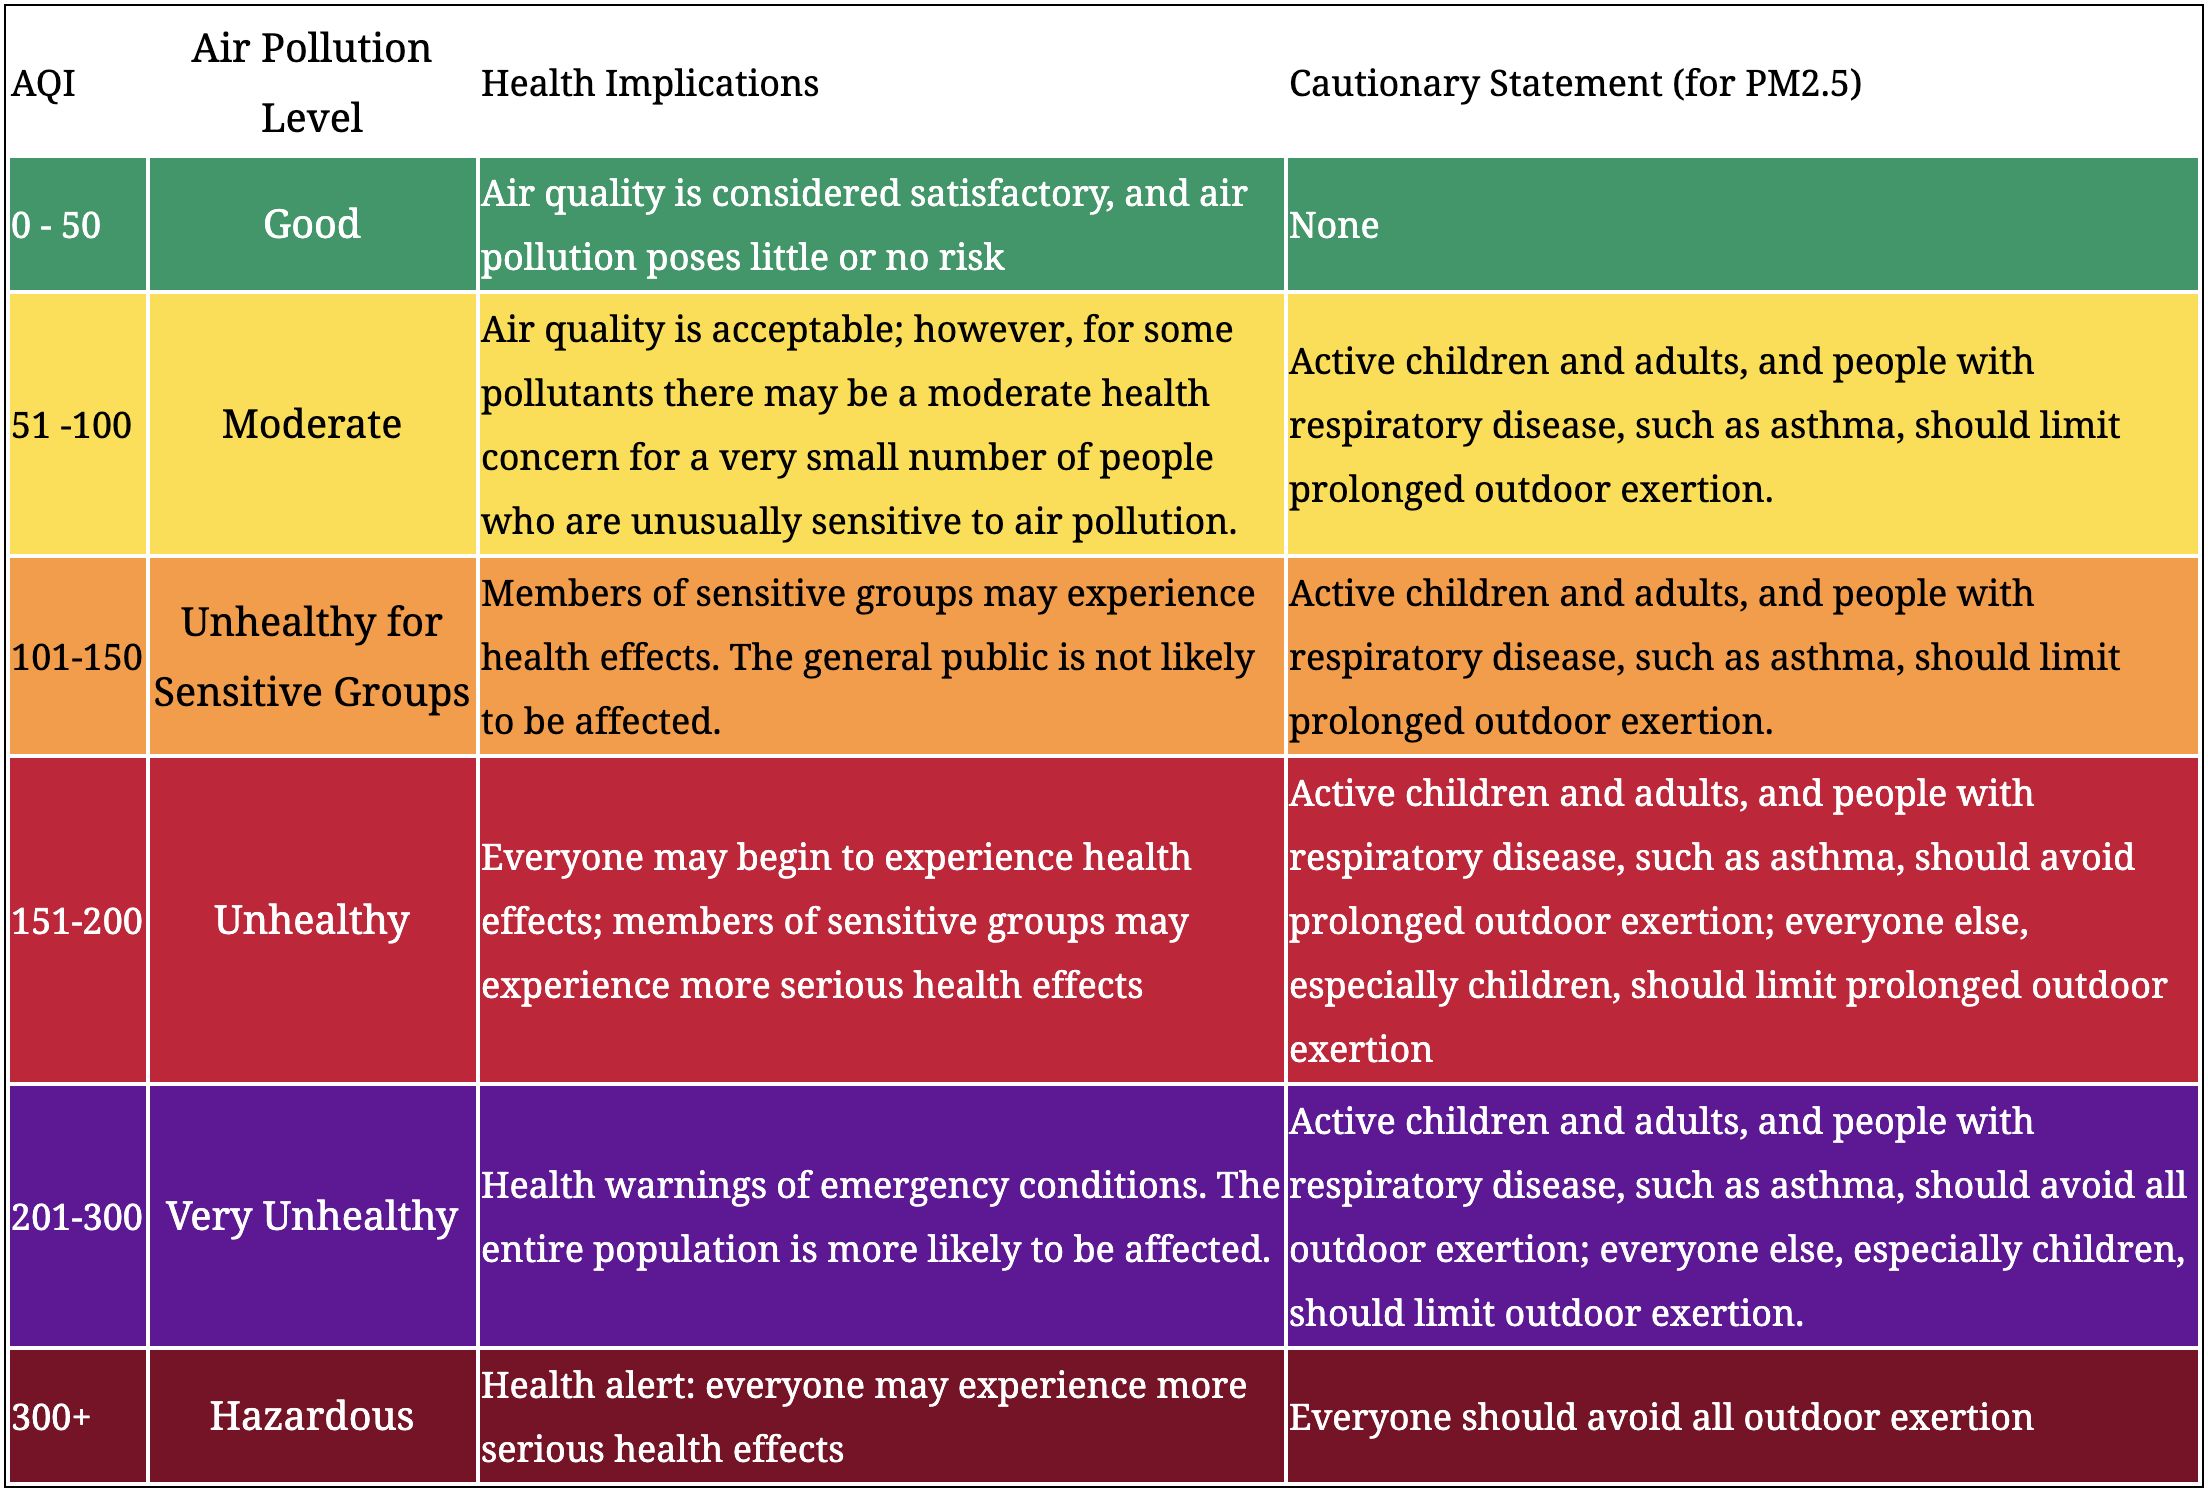
*AQI values from https://aqicn.org/scale/*

In this notebook, we will explore how MISR and other datasets can be used to estimate ground level PM2.5 to inform us about air quality conditions.

(AOD to predict pm 2.5, overlaid with public health data. can focus on urban areas in Virginia over the course of 1-5 years for specific use case)

Note: there is also some literature discussing discrepancies between AOD and PM2.5 measurements, specifically inconsistencies in using AOD to predict PM2.5 (from my understanding). More information can be found in the below literature:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2854781/#b4-ehp-118-a110

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2702404/

https://pubs.giss.nasa.gov/docs/2015/2015_Li_li03700v.pdf


In [59]:
import os
import re
from pyhdf.SD import SD, SDC
import numpy as np
import sys
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [60]:
FILE_NAME = 'MYD04_L2.A2011165.1810.006.2014083124801.hdf'
#test using MODIS because there is a lot of existing work with it -
#will replace with misr file and/or the merged file from sedac 
from pyhdf.SD import SD, SDC
hdf=SD(FILE_NAME, SDC.READ)

In [61]:
#grab the latitude information from the file and set bounds
lat = hdf.select('Latitude')
latitude = lat[:]
min_lat=latitude.min()
max_lat=latitude.max()
#grab the longitude information from the file and set bounds
lon = hdf.select('Longitude')
longitude = lon[:]
min_lon=longitude.min()
max_lon=longitude.max()

In [62]:
#select the science data we want 
SDS_NAME='AOD_550_Dark_Target_Deep_Blue_Combined'
sds=hdf.select(SDS_NAME)

In [83]:
attributes=sds.attributes()
scale_factor=attributes['scale_factor']
#get valid range for AOD SDS
#setting the range 
range=sds.getrange()
min_range=min(range)
max_range=max(range)

In [84]:
data=sds.get()
#get data within valid range
valid_data=data.ravel()
#we grab the data from the SDS and return it as a flattened array 
valid_data=[x for x in valid_data if x>=min_range]
valid_data=[x for x in valid_data if x<=max_range]
#we specify below that we can only work with data within the valid range 
valid_data=np.asarray(valid_data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


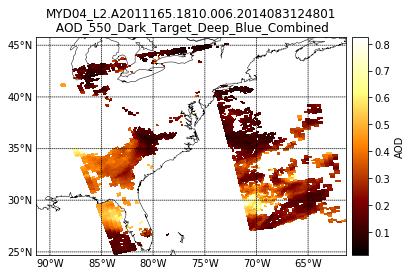

In [87]:
#create a plot of the AOD

attrs = sds.attributes(full=1)
fillvalue=attrs['_FillValue']
# fillvalue[0] is the attribute value (-9999)
fv = fillvalue[0]
#turn fillvalues to NaN
data=data.astype(float)
data[data == fv] = np.nan
#create the map
data = np.ma.masked_array(data, np.isnan(data))
m = Basemap(projection='cyl', resolution='l', llcrnrlat=min_lat, urcrnrlat = max_lat, llcrnrlon=min_lon, urcrnrlon = max_lon)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0, 0, 0, 1])
x, y = m(longitude, latitude)
m.pcolormesh(x, y, data*scale_factor)

plt.autoscale()
#mpl.rcParams['image.cmap'] = 'afmhot'
#create colorbar
cb = m.colorbar()
#label colorboar
cb.set_label('AOD')


#title the plot 
plotTitle=FILE_NAME[:-4]
plt.title('{0}\n {1}'.format(plotTitle, SDS_NAME))
fig = plt.gcf()
# Show the plot window.
plt.show()


In [88]:
#where did this slope and intercept come from? where in the literature can i refer to this? 
#potentially from here
#https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015JD024655

#we use a slope relationship between AOD data and pm2.5 referred to in various literature - will cite, but one is above
#picked average slope for latitude range. will adjust to make actually accurate

#however, if the user knows their relationship they should put in the slope and intercept they want to work with
#added option to do that below. first asks user if they know whats up, if not, uses avg slope and intercept from above

user_input=input('\nWould you like to enter a slope and intercept for the PM 2.5 calculation?')
if user_input == 'Y' or user_input == 'y':
	slope=input('Please enter a slope: ')
	intercept=input('Please enter an intercept: ')
else:
	#if not, use the following:
	slope=30
	intercept=7.05
valid_data=data*scale_factor
pm25=float(slope)*valid_data+float(intercept)


Would you like to enter a slope and intercept for the PM 2.5 calculation?n


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


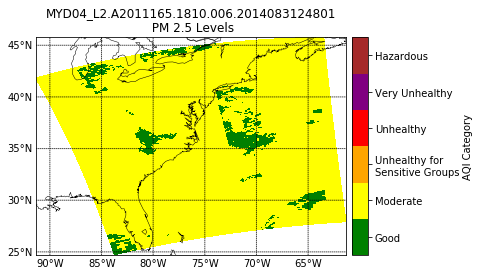


Would you like to save this map? Please enter Y or N 
n

Processing complete.


In [89]:

#turn fillvalues to NaN
data=pm25.astype(float)
data[np.logical_and(data>=0,data <= 12)]=0
data[np.logical_and(data>12,data <= 35.4)]=1
data[np.logical_and(data>35.4,data <= 55.4)]=2
data[np.logical_and(data>55.4,data <= 150.4)]=3
data[np.logical_and(data>150.4,data <= 250.4)]=4
data[data>250.4]=5
data[data < 0] = np.nan
#create the map
data = np.ma.masked_array(data, np.isnan(data))
m = Basemap(projection='cyl', resolution='l', llcrnrlat=min_lat, urcrnrlat = max_lat, llcrnrlon=min_lon, urcrnrlon = max_lon)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0, 0, 0, 1])
x, y = m(longitude, latitude)
my_cmap=LinearSegmentedColormap.from_list('mycmap', ['green','yellow','orange','red','purple','brown'],6)
m.pcolormesh(x, y, data,cmap=my_cmap)
plt.clim(0,6)
#create colorbar
cb = m.colorbar()
cb.set_label('AQI Category')
cb.set_ticks([.5, 1.5,2.5,3.5,4.5,5.5])  # force there to be only 7 ticks
cb.set_ticklabels(['Good', 'Moderate', 'Unhealthy for \nSensitive Groups','Unhealthy','Very Unhealthy','Hazardous'])  # put text labels on them

#title the plot
plotTitle=FILE_NAME[:-4]
plt.title('{0}\n {1}'.format(plotTitle, 'PM 2.5 Levels'))
fig = plt.gcf()
# Show the plot window.
plt.show()
#once you close the map it asks if you'd like to save it
is_save=str(input('\nWould you like to save this map? Please enter Y or N \n'))
if is_save == 'Y' or is_save == 'y':
    #saves as a png if the user would like5
    pngfile = '{0}.png'.format(plotTitle)
    fig.savefig(pngfile)
print('\nProcessing complete.')
